In [1]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import time

import psydac.core.interface as inter

import utilitis_FEEC.derivatives as der
import utilitis_FEEC.projectors as proj
import utilitis_FEEC.evaluation as eva
import utilitis_FEEC.integrate as integr
import utilitis_FEEC.mass_matrices_curved as ma

In [12]:
# ... define boundary conditions in each direction (True: periodic, False: homogeneous Dirichlet)
bc = [False, True, True]
bc_x, bc_y, bc_z = bc


# ... length of computational domain in each direction
Lx = 1
Ly = 1
Lz = 1


# ... number of elements in each direction and corresponding element boundaries
Nel_x = 10
Nel_y = 10
Nel_z = 5

dx = Lx/Nel_x
dy = Ly/Nel_y
dz = Lz/Nel_z

el_b_x = np.linspace(0, Lx, Nel_x + 1)
el_b_y = np.linspace(0, Ly, Nel_y + 1)
el_b_z = np.linspace(0, Lz, Nel_z + 1)


# ... degree of spline basis (of the 0-forms) in each direction
p = [3, 3, 3]
px, py, pz = p


# ... number of basis functions
Nbase = [Nel_x + px, Nel_y + py, Nel_z + pz] 
Nbase_x, Nbase_y, Nbase_z = Nbase


# ... number of degrees of freedom
Nbase_x_0 = Nbase_x - bc_x*px - (1 - bc_x)*2
Nbase_y_0 = Nbase_y - bc_y*py - (1 - bc_y)*2
Nbase_z_0 = Nbase_z - bc_z*pz - (1 - bc_z)*2



# ... knot vectors
if bc_x == True:
    Tx = inter.make_periodic_knots(px, Nbase_x)
else:
    Tx = inter.make_open_knots(px, Nbase_x)
    
if bc_y == True:
    Ty = inter.make_periodic_knots(py, Nbase_y)
else:
    Ty = inter.make_open_knots(py, Nbase_y)
    
if bc_z == True:
    Tz = inter.make_periodic_knots(pz, Nbase_z)
else:
    Tz = inter.make_open_knots(pz, Nbase_z)
    
T = [Tx, Ty, Tz]



# ... define physical domain and mapping from logical domain
R1 = 0.2
R2 = 1.0
dR = R2 - R1

xc = lambda r, phi, z : (r*dR + R1)*np.cos(2*np.pi*phi)
yc = lambda r, phi, z : (r*dR + R1)*np.sin(2*np.pi*phi)
zc = lambda r, phi, z : z


g = lambda r, phi, z : 2*np.pi*dR*(r*dR + R1)
#g = lambda r, phi, z : 1.

G = [[lambda r, phi, z : dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 4*np.pi**2*(r*dR + R1)**2, lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#G = [[lambda r, phi, z : 1., lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]

Ginv = [[lambda r, phi, z : 1/dR**2, lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1/(4*np.pi**2*(r*dR + R1)**2), lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]
#Ginv = [[lambda r, phi, z : 1., lambda r, phi, z : 0., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 1., lambda r, phi, z : 0.], [lambda r, phi, z : 0., lambda r, phi, z : 0., lambda r, phi, z : 1.]]

In [14]:
# ... model with method of manufactured solutions
phi0 = lambda r, phi, z : r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)
f = lambda r, phi, z : -(dR - 4*r*dR - 2*R1)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)/(dR**2*(r*dR + R1)) + 4*r*(1 - r)/(r*dR + R1)**2*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z) + 4*np.pi**2*r*(1 - r)*np.sin(4*np.pi*phi)*np.cos(2*np.pi*z)

In [15]:
# ... mass matrix in V1 and discrete gradient matrix
M1 = ma.mass_matrix_V1(p, Nbase, T, Ginv, g, bc)
G = der.GRAD_3d(p, Nbase, bc)

In [16]:
# ... L2-scalar product of source function in V0

#fun = lambda r, phi, z : 1/g(r, phi, z)*f(r, phi, z)
fun = lambda r, phi, z : f(r, phi, z)

fint = ma.L2_prod_V0(fun, p, Nbase, T, g, bc)

In [17]:
# ... assemble linear system
Block_01 = M1.dot(G)
Block_10 = G.T.dot(M1)
Block_11 = np.zeros((Block_10.shape[0], Block_01.shape[1]))

RHS = np.append(np.zeros(M1.shape[0]), np.reshape(fint, Nbase_x_0*Nbase_y_0*Nbase_z_0))

K = sparse.bmat([[-M1, Block_01], [Block_10, Block_11]], format='csr')

In [18]:
# ... solve linear system
res = sparse.linalg.spsolve(K, RHS)
phivec = res[M1.shape[0]:]

Text(0.5,1,'numerical')

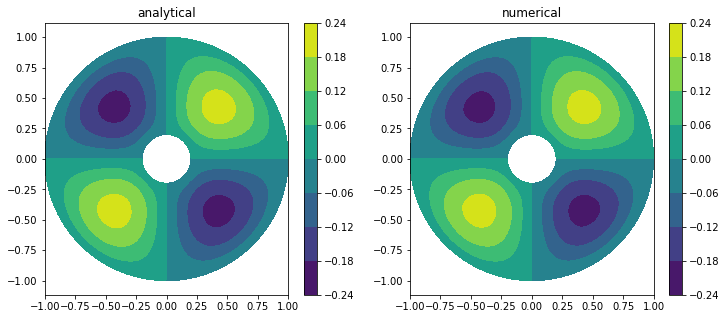

In [27]:
# ... plot analytical and numerical solution

zplot = np.array([0.1])
rplot = np.linspace(0., 1., 100)
phiplot = np.linspace(0., 1., 100)

R, PHI = np.meshgrid(rplot, phiplot, indexing = 'ij')

PHI0 = phi0(R, PHI, zplot)

PHI0_h = eva.evaluate_field_V0(phivec, [rplot, phiplot, zplot], p, Nbase, T, bc)
PHI0_h = np.reshape(PHI0_h, (100, 100))

X, Y = xc(R, PHI, zplot), yc(R, PHI, zplot)

f = plt.figure()
f.set_figwidth(12)
f.set_figheight(5)

plt.subplot(1, 2, 1)

plt.contourf(X, Y, PHI0)
plt.colorbar()
plt.axis('equal')
plt.title('analytical')


plt.subplot(1, 2, 2)

plt.contourf(X, Y, PHI0_h)
plt.colorbar()
plt.axis('equal')
plt.title('numerical')